In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
from IPython.display import HTML

import statistics

pd.set_option('display.max_columns', None)

# Importing the dataset

Dataset Description: https://github.com/washingtonpost/data-police-shootings/tree/master/v2

In [2]:
dataset = pd.read_excel('fatal-police-shootings-data 3.32.02 PM.xls')
print(dataset.shape)

dataset.head()

(8002, 17)


,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


**1. name: The name of the victim.**<br>
**2. date: The date of the fatal shooting.**<br>
**3. manner_of_death: shot or shot and tasered.**<br>
**4. armed: Indicates that the victim was armed.**<br>
**5. age: Age of the victim.**<br>
**6. gender: Gender of the victim.**<br>
**7. race: race of the victim -> W: White, non-Hispanic, B: Black, non-Hispanic, A: Asian, N: Native American, H: Hispanic, O: Other, None: unknown**<br>
**8. city: The municipality where the fatal shooting took place.**<br>
**9. state: postal code abbreviation.**<br>
**10. signs_of_mental_illness: News reports have indicated the victim had a history of mental health issues, expressed suicidal intentions or was experiencing mental distress at the time of the shooting.**<br>
**11. threat_level: Used to classify incidents based on their perceived threat level, with "attack" being the highest level, while "other" and "undetermined" cover various other cases, including those with significant threats and situations where threat levels are not clearly specified.**<br>
**12. flee: Victim was moving away from officers**<br>
**13. body_camera: An officer was wearing a body camera and it may have recorded some portion of the incident.**<br>
**14. latitude and longitude: The location of the shooting**<br>
**15. is_geocoding_exact: Reflects the accuracy of the coordinates. true means that the coordinates are for the location of the shooting (within approximately 100 meters), while false means that coordinates are for the centroid of a larger region, such as the city or county where the shooting happened.**

# Descriptive Statistics

In [3]:
dataset.describe()

,id,date,age,longitude,latitude
count,8002.000000,8002,7499.000000,7162.000000,7162.000000
mean,4415.429643,2019-01-12 00:00:10.797300992,37.209228,-97.040644,36.675719
min,3.000000,2015-01-02 00:00:00,2.000000,-160.007000,19.498000
25%,2240.250000,2017-01-18 00:00:00,27.000000,-112.028250,33.480000
50%,4445.500000,2019-01-25 00:00:00,35.000000,-94.315000,36.105000
75%,6579.750000,2021-01-21 00:00:00,45.000000,-83.151500,40.026750
max,8696.000000,2022-12-01 00:00:00,92.000000,-67.867000,71.301000
std,2497.153259,NaN,12.979490,16.524975,5.379965


## Missing Data

In [4]:
columns_with_missing_data = [feature for feature in dataset.columns if dataset[feature].isnull().sum() > 0]

print("Total number of columns with missing data: ", len(columns_with_missing_data))
print("i.e., {:.2f}% of the rows have missing values".format((len(dataset[dataset.isnull().any(axis = 1)]) / len(dataset))*100))
print(columns_with_missing_data)

Total number of columns with missing data:  8
i.e., 35.28% of the rows have missing values
['name', 'armed', 'age', 'gender', 'race', 'flee', 'longitude', 'latitude']


In [5]:
print("Missing values in percentages: ")
dataset[columns_with_missing_data].isnull().sum().sort_values(ascending = False)*100 / len(dataset)

Missing values in percentages: 


race         18.957761
flee         12.071982
longitude    10.497376
latitude     10.497376
age           6.285929
name          5.673582
armed         2.636841
gender        0.387403
dtype: float64

# Unpacking the date column

In [6]:
dataset['day'] = pd.to_datetime(dataset['date']).dt.day
dataset['month'] = pd.to_datetime(dataset['date']).dt.month
dataset['year'] = pd.to_datetime(dataset['date']).dt.year

# YLL (Years of lives lost)

**References:**<br>
**1. Life Expectancy (as per the year 2021): https://www.cdc.gov/nchs/data/vsrr/vsrr023.pdf**<br>

In [7]:
dataset.race.unique()

array(['A', 'W', 'H', 'B', 'O', nan, 'N'], dtype=object)

**race: W: White, non-Hispanic, B: Black, non-Hispanic, A: Asian, N: Native American, H: Hispanic, O: Other, None: unknown**

In [8]:
life_expectancy_2021 = {'W': {'M': 73.7, 'F': 79.2}, 'B': {'M': 66.7, 'F': 74.8},
                   'A': {'M': 81.2, 'F': 85.6}, 'H': {'M': 74.4, 'F': 81.0}, 'O': {'M': 73.2, 'F': 79.1}}

In [9]:
# Keeping only races W, B, A, H and O (Others). Replacing every other category as O.
def replace_race_categories(race_category):
    
    if race_category == 'W':
        return race_category
        
    elif race_category == 'B':
        return race_category
        
    elif race_category == 'A':
        return race_category
        
    elif race_category == 'H':
        return race_category
        
    elif race_category == 'O':
        return race_category
        
    else:
        return 'O'

In [10]:
dataset['race'].value_counts()

race
W    3300
B    1766
H    1166
A     129
N     105
O      19
Name: count, dtype: int64

**Assumptions:**<br>
**1. Considering race = 'Others' as life expectancy for all remaining races and origins except W, B, H, A, N, and O.**<br>
**2. Dropping NaNs**

In [11]:
print("Before dropping: ", dataset.shape)
dataset = dataset[dataset['race'].notna()]
print("After dropping: ", dataset.shape)

Before dropping:  (8002, 20)
After dropping:  (6485, 20)


In [12]:
dataset['race'] = dataset['race'].apply(replace_race_categories)

dataset['race'].value_counts()

race
W    3300
B    1766
H    1166
A     129
O     124
Name: count, dtype: int64

In [13]:
dataset = dataset[(dataset.race != 'N') & (dataset.race.notna())]
dataset = dataset[(dataset.gender.notna()) & (dataset.age.notna())]
dataset = dataset[(dataset.armed.notna()) & (dataset.flee.notna())]
dataset = dataset[(dataset.longitude.notna()) & (dataset.latitude.notna())]

print(dataset.shape)

dataset.head()

(5194, 20)


,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,day,month,year
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,2,1,2015
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,2,1,2015
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,3,1,2015
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,4,1,2015
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,4,1,2015


In [14]:
dataset.isnull().sum()

id                          0
name                       15
date                        0
manner_of_death             0
armed                       0
age                         0
gender                      0
race                        0
city                        0
state                       0
signs_of_mental_illness     0
threat_level                0
flee                        0
body_camera                 0
longitude                   0
latitude                    0
is_geocoding_exact          0
day                         0
month                       0
year                        0
dtype: int64

**We will drop the name column.**

# Years of Life Lost (YLL)

In [15]:
life_expectancy_2021_df = pd.DataFrame(life_expectancy_2021)
life_expectancy_2021_df

,W,B,A,H,O
M,73.7,66.7,81.2,74.4,73.2
F,79.2,74.8,85.6,81.0,79.1


In [16]:
def calculate_yll(row):
    '''
    This method calculates the years of life lost by matching taking the difference between the life_expectancy and died age of the victim.
    YLL = (life_expectancy - victim_age_when_died)
    '''
    gender = row['gender']
    race = row['race']
    age = row['age']
    
    life_expectancy = life_expectancy_2021_df.loc[gender, race]
    
    yll = np.round(np.float32(life_expectancy) - np.float32(age), 1)
    
    return yll

dataset['yll'] = dataset.apply(calculate_yll, axis=1)

In [17]:
dataset = dataset.drop(['id', 'name', 'date'], axis = 1)

dataset.head()

,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,day,month,year,yll
0,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,2,1,2015,28.200001
1,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,2,1,2015,26.700001
2,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,3,1,2015,51.400002
3,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,4,1,2015,41.700001
4,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,4,1,2015,35.400002


In [18]:
numerical_features = [feature for feature in dataset.columns if dataset[feature].dtype != 'object']
numerical_features = [feature for feature in numerical_features if dataset[feature].dtype != 'bool']

print('Total number of numerical features: ', len(numerical_features))
print(numerical_features)

Total number of numerical features:  7
['age', 'longitude', 'latitude', 'day', 'month', 'year', 'yll']


In [19]:
categorical_features = [feature for feature in dataset.columns if feature not in numerical_features]

print("Total number of categorical features: ", len(categorical_features))
print(categorical_features)

Total number of categorical features:  11
['manner_of_death', 'armed', 'gender', 'race', 'city', 'state', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera', 'is_geocoding_exact']


# Data Analysis

## Most victims died

In [20]:
dataset['race'].value_counts().sort_values(ascending = False) / len(dataset) * 100

race
W    50.885637
B    27.031190
H    18.251829
A     1.983057
O     1.848286
Name: count, dtype: float64

**Most victims are White (50.88%), followed by Black (27.03%), Hispanic (18.25%), Asian (1.98%), and Others (1.485%).**

In [21]:
for race in dataset.race.unique():
    print(f"Median age of victims of {np.median(dataset[dataset['race'] == race]['age'])} is: {race}")

Median age of victims of 35.0 is: A
Median age of victims of 38.0 is: W
Median age of victims of 33.0 is: H
Median age of victims of 31.0 is: B
Median age of victims of 32.0 is: O


**The median age of White is 35.0, Black is 31, Hispanic is 33, Asian is 35 and Other race is 32**

In [22]:
np.median(dataset['age'])

35.0

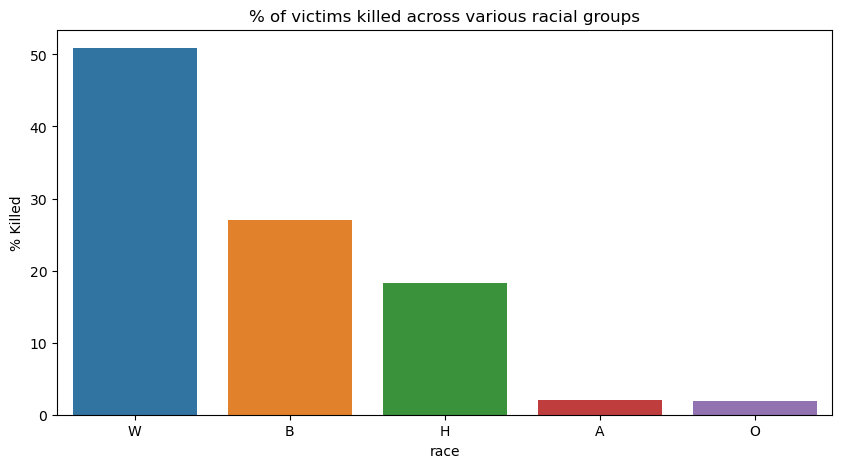

In [23]:
most_victims = dataset['race'].value_counts().sort_values(ascending = False) / len(dataset) * 100
plt.figure(figsize = (10, 5))
sns.barplot(x = most_victims.index, y = most_victims.values)

plt.ylabel('% Killed')
plt.title('% of victims killed across various racial groups')

plt.show()

## Umarmed Victims

**Trends for killing unarmed victims**

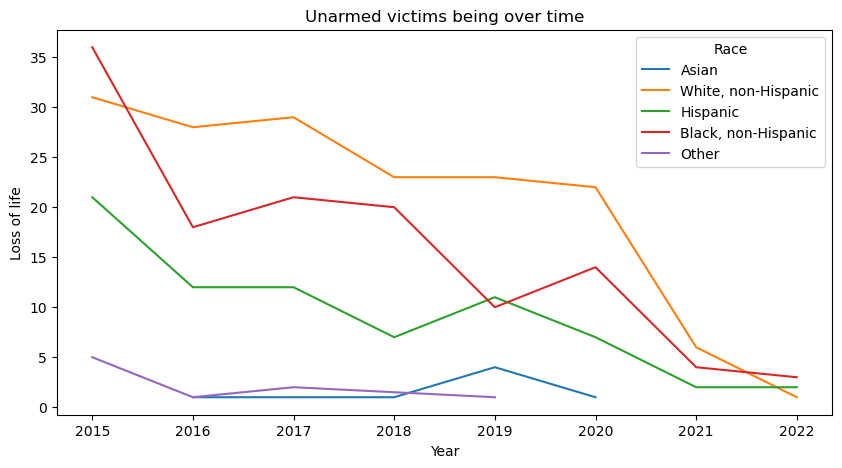

In [24]:
unarmed_victims = dataset[dataset['armed'] == 'unarmed'].groupby(['race', 'year'])['yll'].agg('count')
plt.figure(figsize = (10, 5))

race_dict = {'W': 'White, non-Hispanic', 'B': 'Black, non-Hispanic', 'A': 'Asian', 'N': 'Native American', 'H': 'Hispanic', 'O': 'Other'}

for race in dataset['race'].unique():
    data = unarmed_victims[race]
    sns.lineplot(x = data.index, y = data.values, label = race_dict[race])

plt.xlabel("Year")
plt.ylabel("Loss of life")
plt.title("Unarmed victims being over time")

plt.legend(title = "Race")

plt.show()

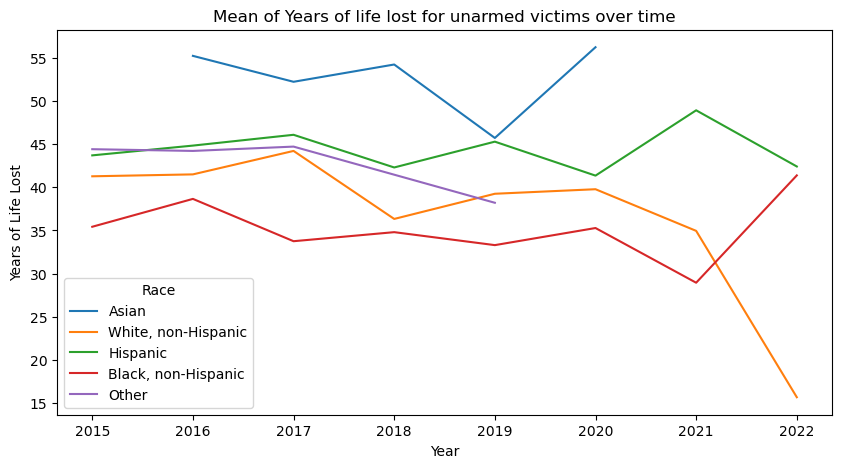

In [25]:
unarmed_victims = dataset[dataset['armed'] == 'unarmed'].groupby(['race', 'year'])['yll'].agg('mean')
plt.figure(figsize = (10, 5))

race_dict = {'W': 'White, non-Hispanic', 'B': 'Black, non-Hispanic', 'A': 'Asian', 'N': 'Native American', 'H': 'Hispanic', 'O': 'Other'}

for race in dataset['race'].unique():
    data = unarmed_victims[race]
    sns.lineplot(x = data.index, y = data.values, label = race_dict[race])

plt.xlabel("Year")
plt.ylabel("Years of Life Lost")
plt.title("Mean of Years of life lost for unarmed victims over time")

plt.legend(title = "Race")

plt.show()

## Group means over time

In [26]:
dataset.head()

,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,day,month,year,yll
0,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,2,1,2015,28.200001
1,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,2,1,2015,26.700001
2,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,3,1,2015,51.400002
3,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,4,1,2015,41.700001
4,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,4,1,2015,35.400002


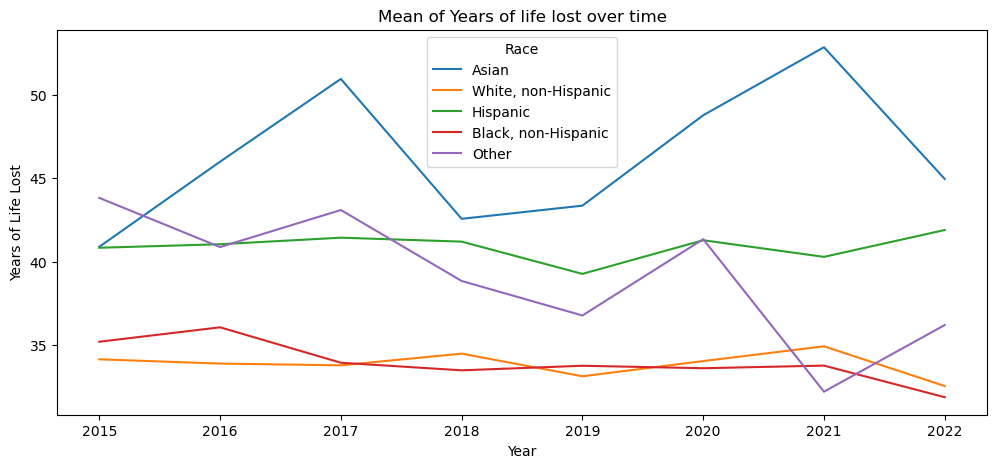

In [27]:
group_means = dataset.groupby(['race', 'year'])['yll'].agg('mean')

plt.figure(figsize = (12, 5))

race_dict = {'W': 'White, non-Hispanic', 'B': 'Black, non-Hispanic', 'A': 'Asian', 'N': 'Native American', 'H': 'Hispanic', 'O': 'Other'}

for race in dataset['race'].unique():
    data = group_means[race]
    sns.lineplot(x = data.index, y = data.values, label = race_dict[race])

plt.xlabel("Year")
plt.ylabel("Years of Life Lost")
plt.title("Mean of Years of life lost over time")

plt.legend(title = "Race")

plt.show()

**The mean years of life lost is almost similar for racial groups Asian-Hispanic, and White-Black.**<br>
**The trend line between the White-Black racial groups moved very close to each other from the year 2015 to 2021 and is significantly lower at the start of the year 2022.**<br>
**The mean years of life lost is significantly higher for the Asian racial group with the highest peaks recorded in the year 2017 and 2021 respectively.**<br>
**There is a significant drop in the mean of years of life lost and reached the minimum when compared to other groups in the year 2021 and slightly increased by the start of the year 2022.**<br>

## Variance of years of life lost over time

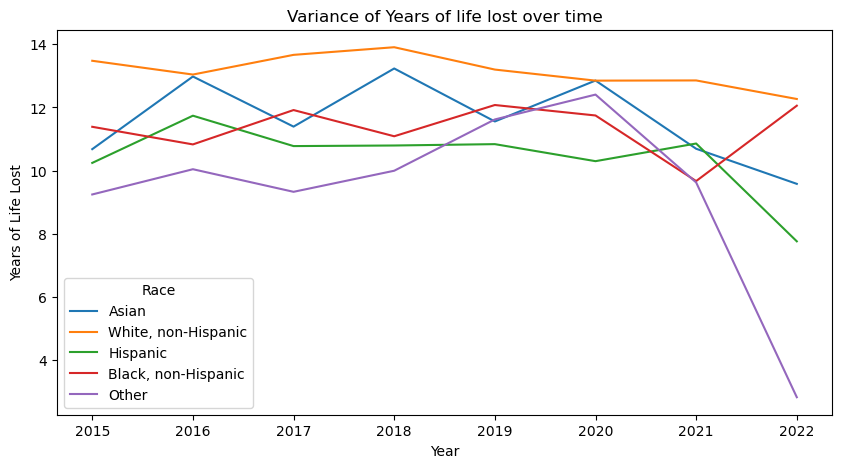

In [28]:
group_means = dataset.groupby(['race', 'year'])['yll'].agg('std')

plt.figure(figsize = (10, 5))

race_dict = {'W': 'White, non-Hispanic', 'B': 'Black, non-Hispanic', 'A': 'Asian', 'N': 'Native American', 'H': 'Hispanic', 'O': 'Other'}

for race in dataset['race'].unique():
    data = group_means[race]
    sns.lineplot(x = data.index, y = data.values, label = race_dict[race])

plt.xlabel("Year")
plt.ylabel("Years of Life Lost")
plt.title("Variance of Years of life lost over time")

plt.legend(title = "Race")

plt.show()

**It is clear that the data is not consistent over the years.**<br>
**The other racial group's variation is increased significantly from the year 2017 to 2020 and suddenly dropped drastically in the year 2022.**<br>
**Low fluctuations in years of life lost is found in White, non-Hispanic and is constantly reducing.**<br>
**We can see repeated pattern for the variance in asian racial group from the year 2015 to 2021.**

# Categorical Features

## Cardinality

In [29]:
dataset.head()

,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,day,month,year,yll
0,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,2,1,2015,28.200001
1,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,2,1,2015,26.700001
2,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,3,1,2015,51.400002
3,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,4,1,2015,41.700001
4,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,4,1,2015,35.400002


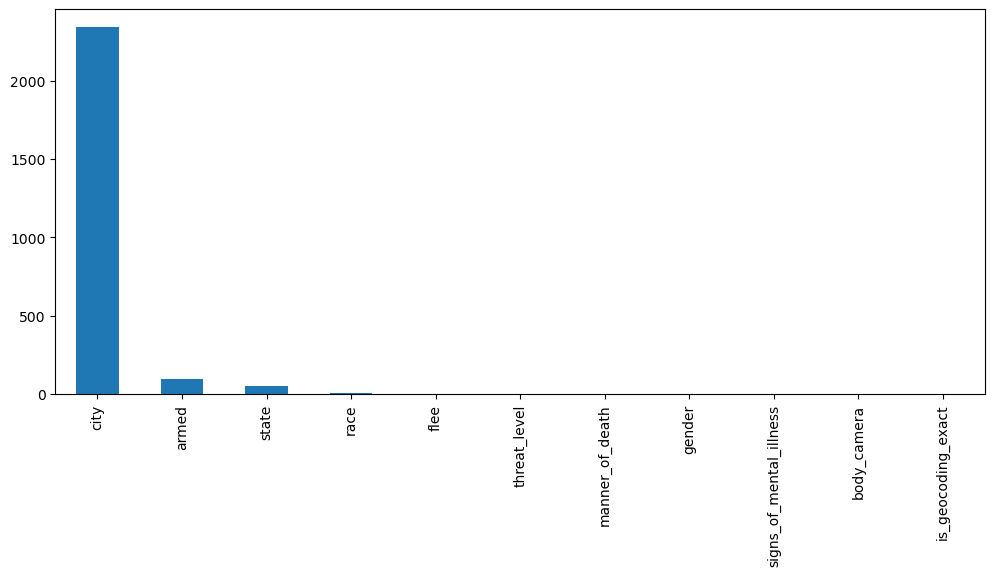

In [30]:
dataset[categorical_features].nunique().sort_values(ascending = False).plot.bar(figsize = (12, 5))

plt.show()

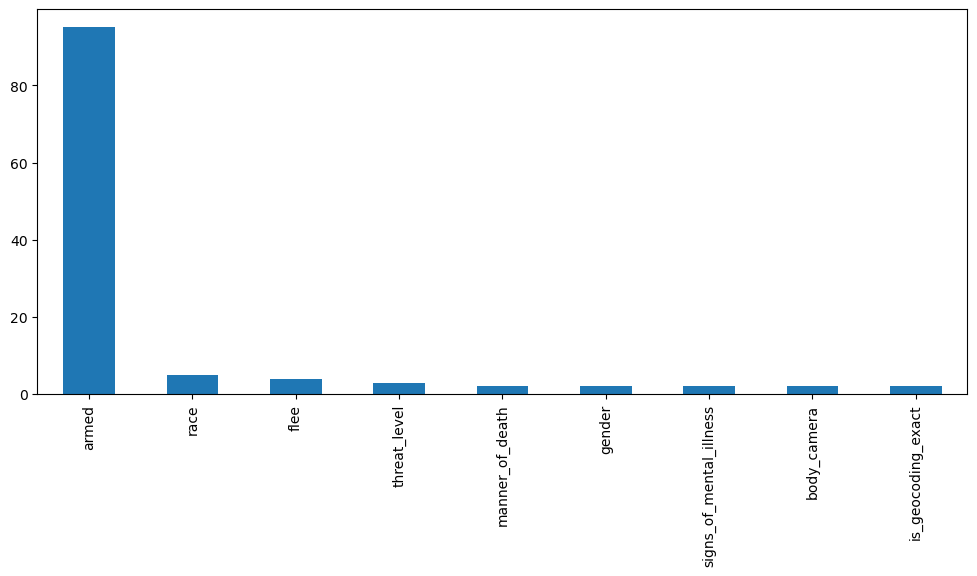

In [31]:
dataset.drop(['city', 'state'], axis = 1, inplace = True)
categorical_features.remove('city')
categorical_features.remove('state')

dataset[categorical_features].nunique().sort_values(ascending = False).plot.bar(figsize = (12, 5))

plt.show()

In [32]:
dataset['flee'] = dataset['flee'].map({'Not fleeing': 'Not_fleeing', 'Foot': 'Foot', 'Car': 'Car', 'Other': 'Other'})

In [33]:
dataset['armed'].unique()

array(['gun', 'unarmed', 'toy weapon', 'nail gun', 'knife', 'shovel',
       'vehicle', 'hammer', 'hatchet', 'sword', 'machete', 'box cutter',
       'undetermined', 'metal object', 'screwdriver', 'lawn mower blade',
       'flagpole', 'guns and explosives', 'cordless drill', 'BB gun',
       'metal pole', 'Taser', 'metal pipe', 'metal hand tool',
       'blunt object', 'metal stick', 'sharp object', 'meat cleaver',
       'carjack', 'chain', "contractor's level", 'railroad spikes',
       'stapler', 'beer bottle', 'crossbow', 'unknown weapon',
       'binoculars', 'pellet gun', 'bean-bag gun',
       'baseball bat and fireplace poker', 'straight edge razor',
       'gun and knife', 'ax', 'brick', 'baseball bat', 'hand torch',
       'chain saw', 'garden tool', 'pair of scissors', 'pole', 'pick-axe',
       'flashlight', 'spear', 'chair', 'pitchfork', 'hatchet and gun',
       'rock', 'piece of wood', 'glass shard', 'motorcycle',
       'pepper spray', 'metal rake', 'baton', 'crowbar',

In [34]:
len(['gun', 'unarmed', 'toy weapon', 'nail gun', 'knife', 'shovel',
       'vehicle', 'hammer', 'hatchet', 'sword', 'machete', 'box cutter',
       'undetermined', 'metal object', 'screwdriver', 'lawn mower blade',
       'flagpole', 'guns and explosives', 'cordless drill', 'BB gun',
       'metal pole', 'Taser', 'metal pipe', 'metal hand tool',
       'blunt object', 'metal stick', 'sharp object', 'meat cleaver',
       'carjack', 'chain', "contractor's level", 'railroad spikes',
       'stapler', 'beer bottle', 'crossbow', 'unknown weapon',
       'binoculars', 'pellet gun', 'bean-bag gun',
       'baseball bat and fireplace poker', 'straight edge razor',
       'gun and knife', 'ax', 'brick', 'baseball bat', 'hand torch',
       'chain saw', 'garden tool', 'pair of scissors', 'pole', 'pick-axe',
       'flashlight', 'spear', 'chair', 'pitchfork', 'hatchet and gun',
       'rock', 'piece of wood', 'glass shard', 'motorcycle',
       'pepper spray', 'metal rake', 'baton', 'crowbar', 'oar',
       'machete and gun', 'air conditioner', 'pole and knife', 'pipe',
       'baseball bat and bottle', 'fireworks', 'pen', 'chainsaw',
       'gun and sword', 'gun and car', 'incendiary device',
       'samurai sword', 'bow and arrow', 'gun and vehicle',
       'vehicle and gun', 'wrench', 'walking stick', 'barstool',
       'BB gun and vehicle', 'wasp spray', 'air pistol',
       'vehicle and machete', 'ice pick', 'tire iron', 'bottle',
       'gun and machete', 'Airsoft pistol', 'knife and vehicle',
       'ax and machete', 'flare gun'])

95

## Making groups in armed feature

**Since there are 95 unique types of weapons are there, I am making them into few groups to reduce the dimension of our dataset.**

In [35]:
dataset.isnull().sum()

manner_of_death            0
armed                      0
age                        0
gender                     0
race                       0
signs_of_mental_illness    0
threat_level               0
flee                       0
body_camera                0
longitude                  0
latitude                   0
is_geocoding_exact         0
day                        0
month                      0
year                       0
yll                        0
dtype: int64

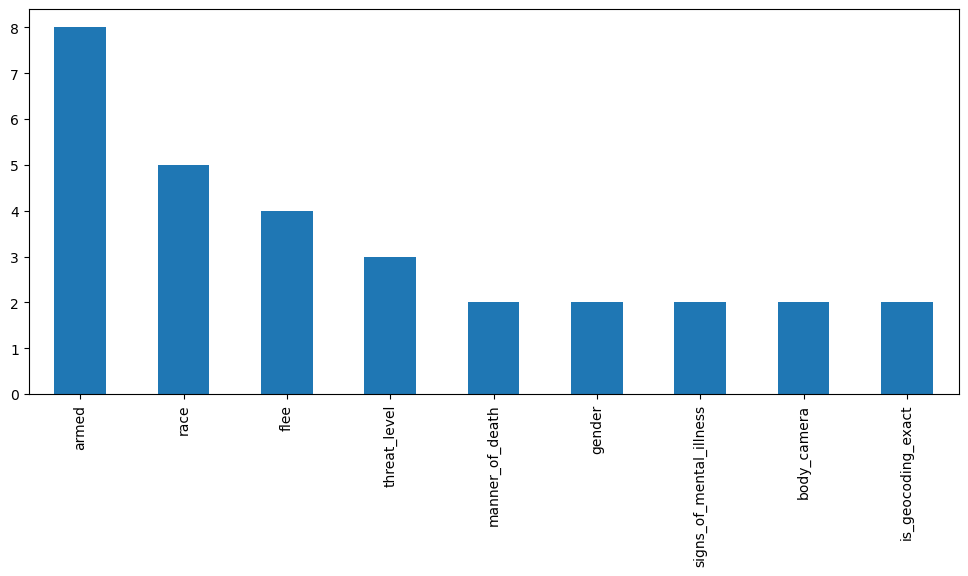

In [36]:
armed_categories = {
    'Firearms': ['gun', 'BB gun', 'pellet gun', 'guns and explosives', 'Taser', 'air pistol', 'flare gun', 'Airsoft pistol'],
    
    'Edged_Weapons': ['knife', 'sword', 'machete', 'hatchet', 'sharp object', 'straight edge razor', 'samurai sword', 
                      'meat cleaver', 'knife and vehicle', 'ax', 'hatchet and gun', 'gun and machete', 'gun and sword', 
                      'ax and machete', 'vehicle', 'box cutter', 'gun and knife', 'chain saw', 'spear'],
    
    'Blunt_Objects': ['hammer', 'baseball bat', 'baseball bat and bottle', 'barstool', 'baseball bat and fireplace poker', 
                      'shovel', 'blunt object', 'crowbar', 'pick-axe', 'piece of wood'],
    
    'Tools_and_Construction_Items': ['cordless drill', 'metal pole', 'metal object', 'metal stick', 'chain', "contractor's level", 
                                     'railroad spikes', 'stapler', 'chainsaw', 'wrench', 'metal rake', 'cordless drill', 
                                     'garden tool'],
    
    'Improvised_Weapons': ['chair', 'brick', 'rock', 'pole', 'flashlight', 'pen', 'beer bottle', 'lawn mower blade', 'pitchfork', 
                           'bow and arrow', 'railroad spikes', 'bottle', 'flagpole', 'ice pick', 'oar', 'air conditioner', 
                           'fireworks', 'incendiary device', 'chainsaw', 'pepper spray'],
    
    'Non_lethal_Weapons': ['Taser', 'pair of scissors', 'baton', 'bean-bag gun', 'Airsoft pistol'],
    
    'Not_Weapons': ['unarmed', 'toy weapon', 'nail gun', 'undetermined', 'screwdriver', 'carjack', 'unknown weapon', 'binoculars', 
    'pellet gun', 'metal hand tool', 'hand torch', 'metal pipe', 'pole and knife', 'pipe', 'vehicle and machete', 'wasp spray', 
    'motorcycle', 'walking stick', 'tire iron'],
    
    'Miscellaneous_Weapons': ['crossbow', 'glass shard', 'shovel', 'machete and gun', 'gun and car', 'gun and vehicle', 
                              'vehicle and gun', 'BB gun and vehicle'],
}

# Creating a dictionary to map items to their categories
item_to_category = {}
for category, items in armed_categories.items():
    for item in items:
        item_to_category[item] = category

dataset['armed'] = dataset['armed'].map(item_to_category)

dataset[categorical_features].nunique().sort_values(ascending = False).plot.bar(figsize = (12, 5))
plt.show()

# Numerical Features

In [37]:
dataset.drop(['day', 'month', 'year'], axis = 1, inplace = True)

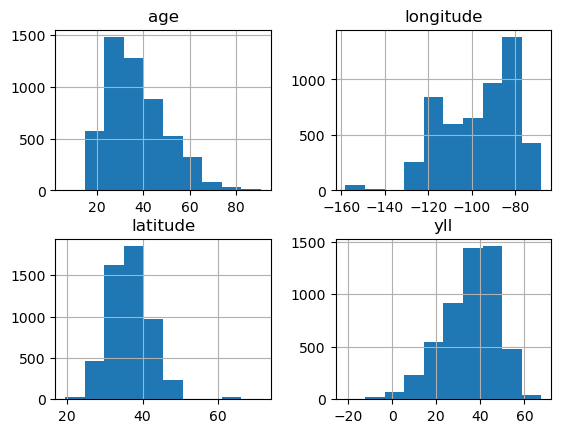

In [38]:
numerical_features.remove('day')
numerical_features.remove('month')
numerical_features.remove('year')

dataset[numerical_features].hist()

plt.show()

# Categorical Features

In [39]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5194 entries, 0 to 7990
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   manner_of_death          5194 non-null   object 
 1   armed                    5194 non-null   object 
 2   age                      5194 non-null   float64
 3   gender                   5194 non-null   object 
 4   race                     5194 non-null   object 
 5   signs_of_mental_illness  5194 non-null   bool   
 6   threat_level             5194 non-null   object 
 7   flee                     5194 non-null   object 
 8   body_camera              5194 non-null   bool   
 9   longitude                5194 non-null   float64
 10  latitude                 5194 non-null   float64
 11  is_geocoding_exact       5194 non-null   bool   
 12  yll                      5194 non-null   float32
dtypes: bool(3), float32(1), float64(3), object(6)
memory usage: 441.3+ KB


In [40]:
dataset['signs_of_mental_illness'] = dataset['signs_of_mental_illness'].astype('object')
dataset['body_camera'] = dataset['body_camera'].astype('object')
dataset['is_geocoding_exact'] = dataset['is_geocoding_exact'].astype('object')

In [41]:
from feature_engine.encoding import OneHotEncoder

encoder = OneHotEncoder(variables = categorical_features, drop_last = True)
dataset = encoder.fit_transform(dataset)

dataset.head()

,age,longitude,latitude,yll,manner_of_death_shot,armed_Firearms,armed_Not_Weapons,armed_Edged_Weapons,armed_Miscellaneous_Weapons,armed_Blunt_Objects,armed_Tools_and_Construction_Items,armed_Improvised_Weapons,gender_M,race_A,race_W,race_H,race_B,signs_of_mental_illness_True,threat_level_attack,threat_level_other,flee_Not_fleeing,flee_Car,flee_Foot,body_camera_False,is_geocoding_exact_True
0,53.0,-123.122,47.247,28.200001,1,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,1,1
1,47.0,-122.892,45.487,26.700001,1,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,1
2,23.0,-97.281,37.695,51.400002,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,1
3,32.0,-122.422,37.763,41.700001,1,0,1,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,1,1
4,39.0,-104.692,40.384,35.400002,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,1


In [42]:
dataset.isnull().sum()

age                                   0
longitude                             0
latitude                              0
yll                                   0
manner_of_death_shot                  0
armed_Firearms                        0
armed_Not_Weapons                     0
armed_Edged_Weapons                   0
armed_Miscellaneous_Weapons           0
armed_Blunt_Objects                   0
armed_Tools_and_Construction_Items    0
armed_Improvised_Weapons              0
gender_M                              0
race_A                                0
race_W                                0
race_H                                0
race_B                                0
signs_of_mental_illness_True          0
threat_level_attack                   0
threat_level_other                    0
flee_Not_fleeing                      0
flee_Car                              0
flee_Foot                             0
body_camera_False                     0
is_geocoding_exact_True               0


# Feature Scaling

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dataset[numerical_features] = scaler.fit_transform(dataset[numerical_features])

dataset.head()

,age,longitude,latitude,yll,manner_of_death_shot,armed_Firearms,armed_Not_Weapons,armed_Edged_Weapons,armed_Miscellaneous_Weapons,armed_Blunt_Objects,armed_Tools_and_Construction_Items,armed_Improvised_Weapons,gender_M,race_A,race_W,race_H,race_B,signs_of_mental_illness_True,threat_level_attack,threat_level_other,flee_Not_fleeing,flee_Car,flee_Foot,body_camera_False,is_geocoding_exact_True
0,1.278819,-1.608274,1.981918,-0.586546,1,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,1,1
1,0.806452,-1.594280,1.652174,-0.705084,1,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,1
2,-1.083015,-0.036014,0.192311,1.246840,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,1
3,-0.374465,-1.565684,0.205051,0.480295,1,0,1,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,1,1
4,0.176630,-0.486926,0.696106,-0.017564,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,1


# GLM (Generalized Linear Model)

**We don't need to perform transformation on the dependent variable to have a normal distribution.**<br>

In [44]:
dataset.columns

Index(['age', 'longitude', 'latitude', 'yll', 'manner_of_death_shot',
       'armed_Firearms', 'armed_Not_Weapons', 'armed_Edged_Weapons',
       'armed_Miscellaneous_Weapons', 'armed_Blunt_Objects',
       'armed_Tools_and_Construction_Items', 'armed_Improvised_Weapons',
       'gender_M', 'race_A', 'race_W', 'race_H', 'race_B',
       'signs_of_mental_illness_True', 'threat_level_attack',
       'threat_level_other', 'flee_Not_fleeing', 'flee_Car', 'flee_Foot',
       'body_camera_False', 'is_geocoding_exact_True'],
      dtype='object')

In [45]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [46]:
all_features = ['age', 'longitude', 'latitude', 'manner_of_death_shot',
       'armed_Firearms', 'armed_Not_Weapons', 'armed_Edged_Weapons',
       'armed_Miscellaneous_Weapons', 'armed_Blunt_Objects',
       'armed_Tools_and_Construction_Items', 'armed_Improvised_Weapons',
       'gender_M', 'race_A', 'race_W', 'race_H', 'race_B',
       'signs_of_mental_illness_True', 'threat_level_attack',
       'threat_level_other', 'flee_Not_fleeing', 'flee_Car', 'flee_Foot',
       'body_camera_False', 'is_geocoding_exact_True']

model = smf.glm(formula = "yll ~ " + " + ".join(all_features), 
                data = dataset, family = sm.families.Gaussian())

result = model.fit()
print(result.summary())

predictions = result.predict()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    yll   No. Observations:                 5194
Model:                            GLM   Df Residuals:                     5169
Model Family:                Gaussian   Df Model:                           24
Link Function:               Identity   Scale:                      0.00032992
Method:                          IRLS   Log-Likelihood:                 13462.
Date:                Wed, 08 Nov 2023   Deviance:                       1.7053
Time:                        19:34:36   Pearson chi2:                     1.71
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

**GLMs are extension of linear regression and are commonly used for regression and classification tasks. They main idea behind GLMs is to model the relationship between a response variable and one or more predictor variables while allowing for different pdfs and link functions.**<br>
**Link funciton is used to connect the linear predictor to the mean of the reponse variable. It can be choosen based on the nature of the data and the relationships that we want to model. For this data, I have chosed "Identity".**<br>
**IRLS (Itertively Reweighted Least squares) is the optimization method I used to estimate the coefficients.**

**Interpretations:**<br>
**Intercept (0.5468):** This is the expected value of the response variable "yll" when all predictor variables are zero. In this context, it represents the baseline or starting value of "yll" when all other factors are absent or equal to zero.<br>
**age (-1.0039):** For each one-unit increase in the "age" of the individual, the expected value of "yll" is expected to decrease by approximately 1.0039 units. This suggests that older individuals tend to have lower values of "yll."<br>
**latitude (0.0007):** A one-unit increase in "latitude" is associated with an increase of 0.0007 units in the expected value of "yll." This means that moving north (increasing latitude) is associated with a slight increase in "yll."<br>
**gender_M (-0.4839):** If the gender of the individual is male ("gender_M" is 1), the expected value of "yll" is expected to be approximately 0.4839 units lower compared to a female ("gender_M" is 0), holding all other variables constant.<br>
**race_A (0.6247):** Individuals of race "A" are expected to have a "yll" value that is approximately 0.6247 units higher than individuals of other races (e.g., compared to "race_W," "race_H," and "race_B"), holding all other variables constant.<br>
**body_camera_False (0.0010):** If "body_camera_False" is true (1), it's associated with an expected increase of 0.0010 units in "yll" compared to when "body_camera_False" is false (0), holding all other variables constant. This suggests that when body cameras are not used, "yll" is slightly higher.<br>

**Degrees of Freedom Residual (df residual = 5169):** It represents the number of data points that can vary freely once our model's parameters have been estimated. For this model 5169 degrees of freedom are left after fitting the model, which suggests that the model is relatively simple in terms of parameter estimation, given the large dataset size.
**Degrees of Freedom Model (df model = 24):** It indicates the number of parameters or predictor variables in your GLM model. We have 24 predictor variables included in the model.<br>
**Log-Likelihood (13462.0):** The log-likelihood value is a measure of how well the GLM fits the data. A higher log-likelihood value suggests a better fit, and the value of 13462.0 indicates a relatively good fit to the data.<br>
**Deviance (1.7):** The deviance is a measure of the goodness of fit, with a smaller value indicating a better fit. For deviance 1.7 suggests that the model provides a reasonable explanation of the data.<br>
**Pearson Chi-squared (1.71):** The Pearson chi-squared statistic is another measure of goodness of fit. It's similar to the deviance and provides additional information on how well the model fits the data. A value close to the deviance suggests a reasonable fit.<br>
**Pseudo R-squared (1.00):** It suggests that our model explains all of the variance in the data.

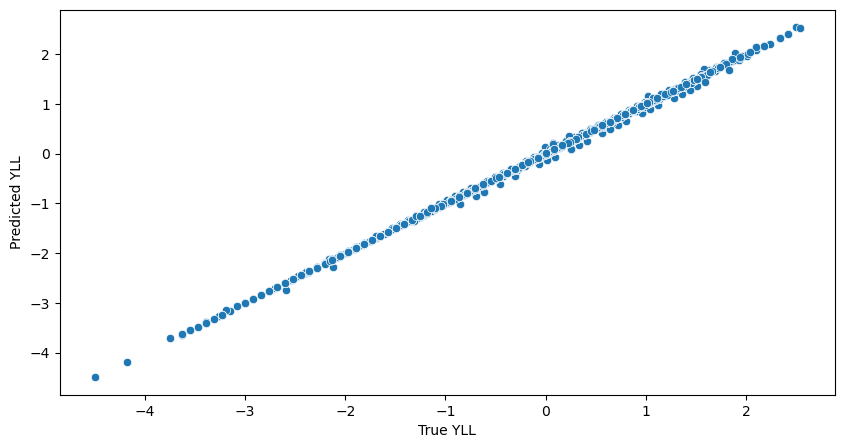

In [51]:
plt.figure(figsize = (10, 5))

sns.scatterplot(x = dataset['yll'], y = predictions)



plt.xlabel('True YLL')
plt.ylabel('Predicted YLL')

plt.show()

**There is a strong linear positive pattern and a positive linear relationship between the original values and the predictions.**<br>
**It suggests that the model's predictions are unbiased, and the residuals are randomly scattered around zero.**